In [1]:
import analyse
from sys import platform
import os
import re
import importlib
import MDAnalysis as mda
import MDAnalysis.analysis.rms as rms
import MDAnalysis.analysis.hbonds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def save_figure(fig, target):
    fig.savefig(target)

In [3]:
importlib.reload(analyse)

<module 'analyse' from '/net/grouphome/ag-bondar/Eva_Bert/code/analyse.py'>

#### Define work folder:

In [4]:
PDB_CODE = '4djh'
SEQ = 'A'
folder = '../'+PDB_CODE+SEQ+'/'
results_folder = folder+'results/'
plot_folder = folder+'plots/'

#### Load trajectory files:

In [5]:
prod_file_count = len(sorted([results_folder+'namd/'+i for i in os.listdir(results_folder+'namd/') if re.match(r'(step7.).*\_production.dcd$', i)]))
prod_dcd = [results_folder+'namd/step7.'+str(i)+'_production.dcd' for i in range(1,prod_file_count+1)]
eq_dcd = [results_folder+'namd/step6.'+str(i)+'_equilibration.dcd' for i in range(1,7)]
all_dcd = list(np.concatenate((eq_dcd, prod_dcd)))
print(all_dcd)

['../6b73B/results/namd/step6.1_equilibration.dcd', '../6b73B/results/namd/step6.2_equilibration.dcd', '../6b73B/results/namd/step6.3_equilibration.dcd', '../6b73B/results/namd/step6.4_equilibration.dcd', '../6b73B/results/namd/step6.5_equilibration.dcd', '../6b73B/results/namd/step6.6_equilibration.dcd', '../6b73B/results/namd/step7.1_production.dcd', '../6b73B/results/namd/step7.2_production.dcd', '../6b73B/results/namd/step7.3_production.dcd', '../6b73B/results/namd/step7.4_production.dcd', '../6b73B/results/namd/step7.5_production.dcd', '../6b73B/results/namd/step7.6_production.dcd', '../6b73B/results/namd/step7.7_production.dcd', '../6b73B/results/namd/step7.8_production.dcd', '../6b73B/results/namd/step7.9_production.dcd', '../6b73B/results/namd/step7.10_production.dcd', '../6b73B/results/namd/step7.11_production.dcd', '../6b73B/results/namd/step7.12_production.dcd', '../6b73B/results/namd/step7.13_production.dcd', '../6b73B/results/namd/step7.14_production.dcd', '../6b73B/result

# RMSD

#### RMSD of all trajectory:

/home/bertalae93/miniconda3/lib/python3.7/site-packages/MDAnalysis/topology/PDBParser.py:272: UserWarning: Serial numbers went over 100,000.  Higher serials have been guessed
  warnings.warn("Serial numbers went over 100,000.  "
/home/bertalae93/miniconda3/lib/python3.7/site-packages/MDAnalysis/topology/PDBParser.py:349: UserWarning: Invalid atom serials were present, bonds will not be parsed
  warnings.warn("Invalid atom serials were present, bonds will not"
/home/bertalae93/miniconda3/lib/python3.7/site-packages/MDAnalysis/topology/PDBParser.py:187: UserWarning: Invalid atom serials were present, bonds will not be parsed
  warnings.warn("Invalid atom serials were present, "


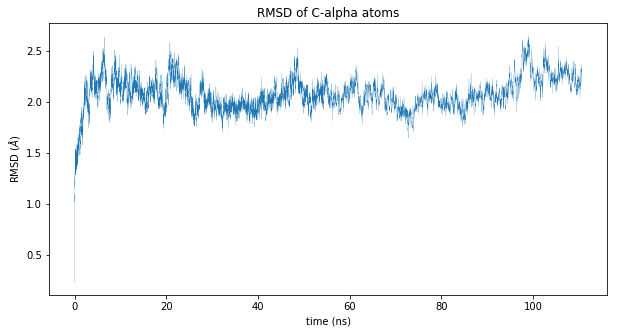

In [6]:
all_traj =  mda.Universe(results_folder+'step5_assembly.xplor_ext.psf', all_dcd)
# all_traj =  mda.Universe(results_folder+'step5_assembly.psf', all_dcd)


# ref = mda.Universe(folder+PDB_CODE+'_inp.pdb')
ref = mda.Universe(results_folder+'step5_assembly.namd.pdb')
# ref = mda.Universe(results_folder+'namd/step5_charmm2namd.pdb')

title = 'RMSD of C-alpha atoms'
R, r_fig = analyse.rmsd_traj(all_traj, ref, title)

In [7]:
save_figure(r_fig[0].figure, plot_folder+'all_rmsd')

In [8]:
np.savetxt(plot_folder+'all_rmsd.txt', R.T)

In [9]:
print(np.average(R[2]))

2.0440311476080475


#### RMSD of production steps:

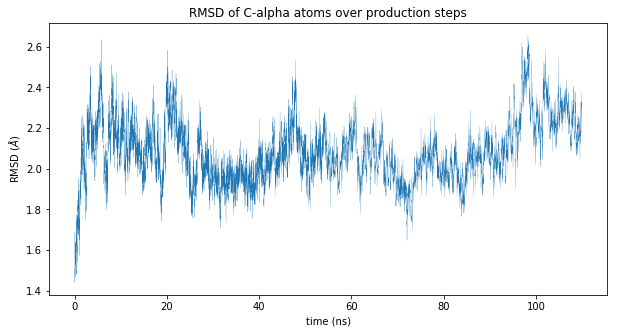

In [10]:
prod_traj = mda.Universe(results_folder+'step5_assembly.xplor_ext.psf', prod_dcd)
# prod_traj = mda.Universe(results_folder+'step5_assembly.psf', prod_dcd)

title = 'RMSD of C-alpha atoms over production steps'
R_prod, r_fig = analyse.rmsd_traj(prod_traj, ref, title)

In [11]:
save_figure(r_fig[0].figure, plot_folder+'prod_rmsd')

In [12]:
np.savetxt(plot_folder+'prod_rmsd.txt', R_prod.T)

### Structure analysis of the protein:

In [ ]:
# pdb_file = folder+PDB_CODE+'_inp.pdb'
# struct = analyse.secondary_structure(pdb_file, PDB_CODE)
# print(struct)

In [ ]:
loop_inf = np.loadtxt(folder+'loop_inf.txt', dtype='int')
helix = np.array([])
for row in loop_inf:
    helix = np.concatenate((helix, np.arange(row[1], row[2]+1)))
struct = {'helix': helix}
print(struct)

# RMSF:

#### RMSF over production steps:

In [ ]:
rmsf_fig, resnum, rmsf = analyse.rmsf_plot([prod_traj], title='RMSF of residues over production step', structure=struct)

In [ ]:
save_figure(rmsf_fig, plot_folder+'prod_rmsf')

In [ ]:
data = np.array([resnum, rmsf])
np.savetxt(plot_folder+'rmsf_prod.txt', data.T)

## RMSD of the loops:

In [13]:
r = rms.RMSD(prod_traj.select_atoms('name CA'),
             ref.select_atoms('name CA'), 
             select='name CA', 
             groupselections=['name CA and resid 3-33',
                              'name CA and resid 39-67',
                              'name CA and resid 72-107', 
                              'name CA and resid 118-142',
                              'name CA and resid 167-201',
                              'name CA and resid 210-245',
                              'name CA and resid 252-279']).run()

In [14]:
R = r.rmsd.T
frame = R[0]
time = R[1]
r_all = np.average(R[2])

r1 = np.average(R[3])
r2 = np.average(R[4])
r3 = np.average(R[5])
r4 = np.average(R[6])
r5 = np.average(R[7])
r6 = np.average(R[8])
r7 = np.average(R[9])

r_helix = np.average([r1, r2, r3, r4, r5, r6, r7])

In [15]:
print(R.shape)

(10, 8218)


Text(0.5, 0, 'time (ns)')

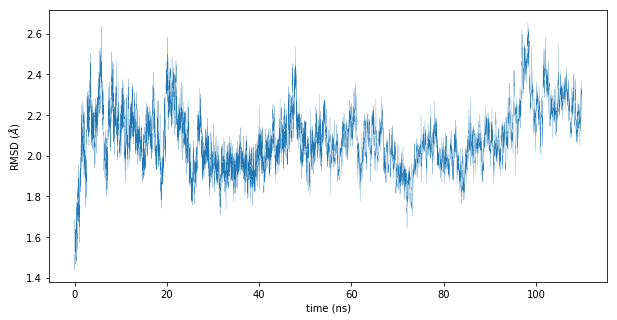

In [16]:
plt.subplots(figsize=(10,5))
fig = plt.plot(time/1000, R[2], linewidth=0.2)
plt.ylabel('RMSD ($\AA$)')
plt.xlabel('time (ns)')

In [17]:
helix_data = {'all atom': [r_all],
              'all TM': r_helix,
              'TM1': r1,
              'TM2': r2,
              'TM3': r3,
              'TM4': r4,
              'TM5': r5,
              'TM6': r6,
              'TM7': r7,
             }
helix_rmsd = pd.DataFrame(data=helix_data)
print(helix_rmsd)

   all atom    all TM       TM1       TM2       TM3       TM4       TM5  \
0  2.076854  1.278687  1.108492  1.211493  1.128612  1.243689  1.052924   

       TM6       TM7  
0  1.70441  1.501189  


In [18]:
helix_rmsd.to_csv(plot_folder+'helix_rmsd.csv')

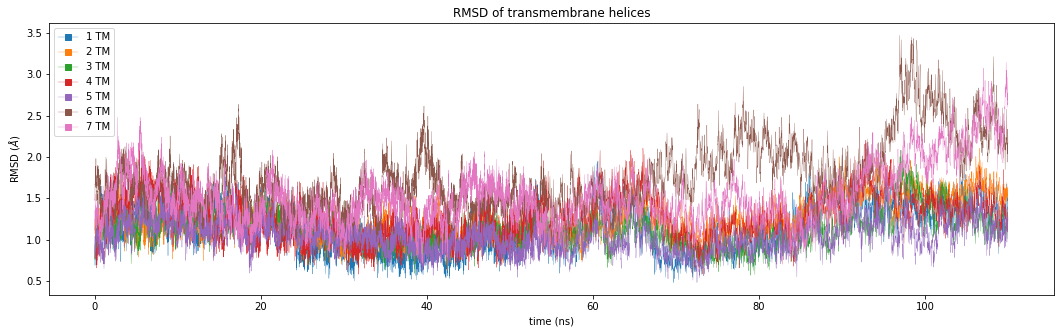

In [19]:
fig, ax = plt.subplots(1, figsize=(18,5))

ax.plot(time/1000, R[3], linewidth=0.3, label='1 TM')
ax.plot(time/1000, R[4], linewidth=0.3, label='2 TM')
ax.plot(time/1000, R[5], linewidth=0.3, label='3 TM')
ax.plot(time/1000, R[6], linewidth=0.3, label='4 TM')
ax.plot(time/1000, R[7], linewidth=0.3, label='5 TM')
ax.plot(time/1000, R[8], linewidth=0.3, label='6 TM')
ax.plot(time/1000, R[9], linewidth=0.3, label='7 TM')
plt.title('RMSD of transmembrane helices')
plt.ylabel('RMSD ($\AA$)')
plt.xlabel('time (ns)')

legend = ax.legend(frameon=True)
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_marker('s')

In [20]:
save_figure(fig, plot_folder+'helix_rmsd')

# PBC

In [ ]:
code = PDB_CODE+SEQ
vmd_mac = '/Applications/VMD\ 1.9.3.app/Contents/Resources/VMD.app/Contents/MacOS/VMD'
vmd_linux = '/net/opt/bin/vmd'

vmd = vmd_linux if platform == 'linux' else vmd_mac

In [ ]:
print(code)
print(vmd)

In [ ]:
def create_file_list(files):
    filelist = ''
    if len(files) > 1: 
        for i in files:
            filelist += i+' '
    else: filelist += files[0]
        
    return {filelist}

In [ ]:
# filelist = create_file_list(prod_dcd)

files = [12, 13]
filelist = create_file_list([results_folder+'namd/step7.'+str(files[i])+'_production.dcd' for i in range(0,len(files))])
print(filelist)

In [ ]:
# ! (cd './tcl' && $vmd  -dispdev text -e pbc.tcl -args $code $filelist > pbc_log.out)

# Water count:

In [ ]:
def concatenate_water_per_frame(water_files):
    waters = np.loadtxt(water_files[0])
    for i in range(1, len(water_files)):
        data = np.loadtxt(water_files[i])
        waters = np.concatenate((waters, data))
    return waters

In [ ]:
def plot_water_within(waters, time, title=''):
    plt.subplots(figsize=(10,5))
    fig = plt.plot(time/1000, waters[:,1], linewidth=0.2)
    plt.ylabel('Number of water')
    plt.xlabel('time (ns)')
    plt.title(title)
    return fig

In [ ]:
def average_water(waters):
    return np.average(waters[:,1])

#### water within protein:

In [ ]:
x = 11
y = 9
z = 15
_x = 13
_y = 12
_z = 18
distance = 5
parameters =  '{} {} {} {} {} {} {}'.format(x, y, z, _x, _y, _z, distance)

In [ ]:
# ! (cd './tcl' && $vmd -dispdev text -e water_within_protein.tcl -args $code $filelist $parameters > water_within_protein_log.out)

In [ ]:
water_files1 = [results_folder+'namd/step7.'+str(i)+'_production.dcd-pbc.dcd-warter_count.txt' for i in range(1,prod_file_count+1)]
water_within_prot = concatenate_water_per_frame(water_files1)

fig_within_prot = plot_water_within(water_within_prot, time, title='Number of water within protein')

In [ ]:
save_figure(fig_within_prot[0].figure, plot_folder+'water_within_protein')
np.savetxt(plot_folder+'water_within_protein.txt', water_within_prot)

In [ ]:
print(average_water(water_within_prot))

#### water count near residue:

In [ ]:
resid = '274'
resname = 'TRP'
distance = 3
parameters =  '{} {} {}'.format(resid, resname, distance)
print(parameters)

In [ ]:
# ! (cd './tcl' && $vmd -dispdev text -e water_near_residue.tcl -args $code $parameters > water_near_residue_log.out)

In [ ]:
water_files2 = [results_folder+'namd/step7.'+str(i)+'_production.dcd-pbc.dcd-warter_3_of_274TRP.txt' for i in range(1,prod_file_count+1)]
water_near_648 = concatenate_water_per_frame(water_files2)
fig_near_648 = plot_water_within(water_near_648, time, title='Number of water near W6.48')

In [ ]:
save_figure(fig_near_648[0].figure, plot_folder+'water_near_W648')
np.savetxt(plot_folder+'water_near_W648.txt', water_near_648)

In [ ]:
print(average_water(water_near_648))

In [ ]:
resid = '128'
resname = 'ASP'
distance = 3
parameters =  '{} {} {}'.format(resid, resname, distance)
print(parameters)

In [ ]:
# ! (cd './tcl' && $vmd -dispdev text -e water_near_residue.tcl -args $code $parameters > water_near_residue_log.out)

In [ ]:
water_files3 = [results_folder+'namd/step7.'+str(i)+'_production.dcd-pbc.dcd-warter_3_of_128ASP.txt' for i in range(1,prod_file_count+1)]
water_near_332 = concatenate_water_per_frame(water_files3)

fig_near_332 = plot_water_within(water_near_332, time, title='Number of water near D3.32')

In [ ]:
save_figure(fig_near_332[0].figure, plot_folder+'water_near_D332')
np.savetxt(plot_folder+'water_near_D332.txt', water_near_332)

In [ ]:
print(average_water(water_near_332))

#### water in binding pocket:

In [ ]:
selection = {'(water within 3 of (resname THR and resid 55) or (resname ASP and resid 84) or (resname LYS and resid 173) or (resname TRP and resid 233) or (resname TYR and resid 266) or (resname GLY and resid 265)) and oxygen'}
print(selection)

In [ ]:
# ! (cd './tcl' && $vmd -dispdev text -e water_in_pocket.tcl -args $code $selection > water_in_pocket_log.out)

In [ ]:
water_files4 = [results_folder+'namd/step7.'+str(i)+'_production.dcd-pbc.dcd-warter_in_pocket.txt' for i in range(1,prod_file_count+1)]
water_pocket = concatenate_water_per_frame(water_files4)

fig_water_pocket = plot_water_within(water_pocket, time, title='Number of water in the ligand binding pocket')

In [ ]:
print(average_water(water_pocket))

In [ ]:
save_figure(fig_water_pocket[0].figure, plot_folder+'water_in_pocket')
np.savetxt(plot_folder+'water_in_pocket.txt', water_pocket)

#### water near in sodium pocket

In [ ]:
selection_sod_pock = {'(water within 3 of (resname ASP and resid 95) or (resname ASN and resid 131) or (resname ASN and resid 310) or (resname ASN and resid 314)) and oxygen'}
print(selection_sod_pock)

In [ ]:
# ! (cd './tcl' && $vmd -dispdev text -e water_in_pocket.tcl -args $code $selection_sod_pock > water_in_pocket_log.out)

In [ ]:
water_files4 = [results_folder+'namd/step7.'+str(i)+'_production.dcd-pbc.dcd-warter_in_pocket.txt' for i in range(1,prod_file_count+1)]
water_pocket = concatenate_water_per_frame(water_files4)

fig_water_pocket = plot_water_within(water_pocket, time, title='Number of water in the sodium binding pocket')

In [ ]:
print(average_water(water_pocket))

In [ ]:
save_figure(fig_water_pocket[0].figure, plot_folder+'water_in_sodium_pocket')
np.savetxt(plot_folder+'water_in_sodium_pocket.txt', water_pocket)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time/1000, water_within_prot[:,1], linewidth=0.2, label='water within protein')
ax.plot(time/1000, water_near_274[:,1], linewidth=0.2, label='water near W6.48')
ax.plot(time/1000, water_near_128[:,1], linewidth=0.2, label='water near D3.32')
# ax.plot(time/1000, water_pocket[:,1], linewidth=0.2, label='water in pocket')
ax.plot(time/1000, water_pocket[:,1], linewidth=0.2, label='water in sodium pocket')


plt.ylabel('Number of water')
plt.xlabel('time (ns)')
plt.title('Number of water in near different parts of protein')

legend = ax.legend(frameon=True)
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_marker('s')

In [ ]:
save_figure(fig, plot_folder+'water_number')

# Sodium ion

In [ ]:
sod_resid = 50
sod_x = -4.959457
sod_y = -6.712894
sod_z = -3.926964

In [ ]:
! (cd './tcl' && $vmd -dispdev text -e sodium_coordinate.tcl -args $code $filelist $sod_resid $sod_x $sod_y $sod_z > sodium_coordinate_log.out)

In [ ]:
prod_file_count = len(prod_dcd)

In [ ]:
sod_coor_files = [results_folder+'namd/step7.'+str(i)+'_production.dcd-sodium_coord.txt' for i in range(1,prod_file_count+1)]
sod_coor = concatenate_water_per_frame(sod_coor_files)

plt.subplots(figsize=(15, 5))
fig = plt.plot(time/1000, sod_coor[:,4], linewidth=0.5)
plt.ylabel('distance')
plt.xlabel('time (ns)')
plt.title('Distance between sodium ion and sodium pocket')

In [ ]:
save_figure(fig[0].figure, plot_folder+'sodium_dist')

In [ ]:
np.savetxt(plot_folder+'sod_coor.txt', sod_coor)